# NCAA tournament data - Neural Network

In [4]:
#for saving and load data files
import pickle
import numpy as np
import train as train
import neuralnetworks as nn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import copy

### Loading NCAA Data

In [5]:
#objects to store data
gameYearData = {} #dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame played by tournament teams
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]

tournamentGameData = {}#dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame in the tournament
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]

teamYearData = {} #dictionary with year as key and value is a dictionary with team as key and value in the form of [[team stats],[opponent stats]] 
#team/oppenent stats: [0G, 1MP, 2FG, 3FGA, 4FG%, 52P, 62PA, 72P%, 83P, 93PA, 103P%, 11FT, 12FTA, 13FT%, 14ORB, 15DRB, 16TRB, 17AST, 18STL, 19BLK, 20TOV, 21PF, 22PTS, 23PTS/G]
#example: '2000': {'Duke': [[34, '', 1045, 2172, 0.481, 761, 1430, 0.532, 284, 742, 0.383, 618, 833, 0.742, 453, 860, 1313, 584, 333, 191, 480, 552, 2992, 88.0], [34, '', 934, 2238, 0.417, 737, 1686, 0.437, 197, 552, 0.357, 360, 537, 0.67, 526, 757, 1283, 472, 240, 123, 607, 690, 2425, 71.3]]}

In [42]:
#webscraping has already been run and the data is saved in files: tournamentGameData.pickle, teamYearData.pickle
#open dicts from file

pickle_in1 = open("teamYearData.pickle","rb")
teamYearData = pickle.load(pickle_in1)

pickle_in2 = open("gameYearData.pickle","rb")
gameYearData = pickle.load(pickle_in2)

pickle_in3 = open("tournamentGameData.pickle","rb")
tournamentGameData = pickle.load(pickle_in3)

In [7]:
#Read in Information about the Over Under values for NCAA Tournament games saved in file valid_classification_games.pkl
#This information looks like (team,opponent,over_under score, Outcome) 
#Outcome = 0 for Under
#Outcome = 1 for Over
over_under_data = []
with open("valid_classification_games.pkl","rb") as f:
    over_under_data = pickle.load(f)

### Data Formatting Functions

In [8]:
def removeTournamentGamesFromData(year): 
    
    newGameYearData=copy.deepcopy(gameYearData)
    newGameYearData[year] = []
    
    for game in gameYearData[year]:
        duplicate = False
        for gameCompare in tournamentGameData[year]:
            if game[2] == gameCompare[2]:
                if (game[0]==gameCompare[0] and game[1]==gameCompare[1]) or (game[1]==gameCompare[0] and game[0]==gameCompare[1]):
                    duplicate = True
        if not duplicate:
            newGameYearData[year].append(game)

    return newGameYearData

In [9]:
def formatData(yearRange,gameData):
    #formatting data for use in nn
    acceptedTeamStats = [4,10,12,13,16,17,20,23]
    acceptedOpponentStats = [4,10,12,13,16,17,20,23]
#2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,23
    years = [i for i in range(yearRange[0],yearRange[1]+1)]

    data = []

    for i in years:
        year = str(i)
        singleSeason = gameData[year]
        singleYearTeamData = teamYearData[year]
    
        for game in singleSeason:
            finalScore = game[2]
            teamStats = []
            for j in range(0,2):
                tempTeamStats = singleYearTeamData[game[j]][0]
                tempOpponentStats = singleYearTeamData[game[j]][1]
                for q in range(0,24):
                    if q in acceptedTeamStats:
                        if tempTeamStats[q]=='':
                            print((year,game[j],q))
                        teamStats.append(tempTeamStats[q])
                    if q in acceptedOpponentStats:
                        if tempOpponentStats[q]=='':
                            print((year,game[j],q))
                        teamStats.append(tempOpponentStats[q])
            teamStats.append(finalScore)
            data.append(teamStats)
            
    formattedData = np.array(data)
    return formattedData

In [100]:
def format_classification_data(over_under):
    acceptedTeamStats = [4,10,12,13,16,17,20,23]
    acceptedOpponentStats = [4,10,12,13,16,17,20,23]
    data = []
    for game in over_under:
        year = game[0][2][-4:]
        singleYearTeamData = teamYearData[year]
        teamStats = []
        try:
            tempTeamStats = singleYearTeamData[game[0][0]][0]
            tempOpponentStats = singleYearTeamData[game[0][1]][0]
            for q in range(0,24):
                    if q in acceptedTeamStats:
                        teamStats.append(tempTeamStats[q])
                    if q in acceptedOpponentStats:
                        teamStats.append(tempOpponentStats[q])
            teamStats.append(game[0][4])
            data.append(teamStats)
        except KeyError:
            print("error")
    over = []
    under = []
    for item in data:
        if item[-1] == 1.0:
            over.append(item)
        else:
            under.append(item)
    sort_data = over+under
    return np.array(sort_data)

In [65]:
print(classification_data)

[[  0.469   0.437   0.397 ...,  75.     59.3     1.   ]
 [  0.455   0.428   0.35  ...,  66.3    70.2     1.   ]
 [  0.453   0.458   0.341 ...,  71.1    72.9     0.   ]
 ..., 
 [  0.486   0.425   0.381 ...,  78.9    70.      1.   ]
 [  0.491   0.425   0.402 ...,  71.     70.      0.   ]
 [  0.483   0.458   0.362 ...,  78.     79.7     0.   ]]


### Formatting Data for use in the Nueral Networks

In [10]:
gameYearData_without2017TourneyData = removeTournamentGamesFromData('2017')

In [11]:
#print(teamYearData['2007']['Virginia Military Institute'])
sum2 = 0
sum3 = 0
sum4 = 0
sum16 = 0
for team,game in teamYearData['2007'].items():
    if(game[1][2]!=''):
        sum2 += game[1][2]
    if(game[1][3]!=''):
        sum3 += game[1][3]
    if(game[1][4]!=''):
        sum4 += game[1][4]
    if(game[1][16]!=''):
        sum16 += game[1][16]
    
average2 = sum2/len(teamYearData['2007'])
average2 = int(average2)
average3 = sum3/len(teamYearData['2007'])
average3 = int(average3)
average4 = sum4/len(teamYearData['2007'])
average16 = sum16/len(teamYearData['2007'])
average16 = int(average16)

In [12]:
#these values missing so given the season averge of all teams
teamYearData['2007']['Pepperdine'][1][16] = average16
teamYearData['2007']['Virginia Military Institute'][1][2] = average2
teamYearData['2007']['Virginia Military Institute'][1][3] = average3
teamYearData['2007']['Virginia Military Institute'][1][4] = average4

In [13]:
trainData = formatData([2010,2017],gameYearData_without2017TourneyData)
trainTdata = trainData[:,-1]
trainTdata = np.row_stack(trainTdata)
trainXdata = trainData[:,0:-1]
trainTdata.shape, trainXdata.shape

((15154, 1), (15154, 32))

In [14]:
testData = formatData([2017,2017],tournamentGameData)
testTdata = testData[:,-1]
testTdata = np.row_stack(testTdata)
testXdata = testData[:,0:-1]
testTdata.shape, testXdata.shape

((63, 1), (63, 32))

In [15]:
len(gameYearData['2017']),len(gameYearData_without2017TourneyData['2017'])

(1895, 1833)

In [16]:
len(tournamentGameData['2017'])

63

In [17]:
trainAllData = formatData([2010,2017],gameYearData)
trainAllTdata = trainAllData[:,-1]
trainAllTdata = np.row_stack(trainAllTdata)
trainAllXdata = trainAllData[:,0:-1]
trainAllTdata.shape, trainAllXdata.shape

((15216, 1), (15216, 32))

## Neural Network Testing

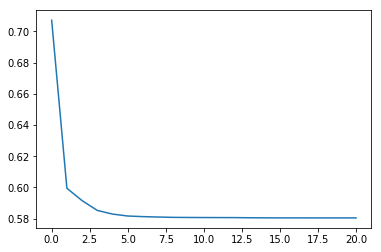

In [18]:
nnet = nn.NeuralNetwork(trainXdata.shape[1], [0], trainTdata.shape[1])
nnet.train(trainXdata, trainTdata, 20)
plt.plot(nnet.getErrorTrace())

In [19]:
iterations = 10
repetitions = 20
nns = [0,2,5,[4,4],[5,5],[1,1,1,1],[3,3,3,3],[3,3,3,3,3]]

#### Training neural network with all games from the 1996-2016 seasons and the regular season of 2017 as training data and with all tournament games from the 2017 season as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 15.966666810399857, 15.045231605535696, 0.7430999279022217]
[2, 16.583666073625885, 15.506442042822362, 4.199825763702393]
[5, 17.35469053088741, 16.169658351361065, 3.734480142593384]
[[4, 4], 16.469624795656422, 15.277148946859388, 8.819187879562378]
[[5, 5], 16.507308074839159, 15.250075564300863, 7.729074954986572]
[[1, 1, 1, 1], 17.889399969488437, 16.718500410708188, 3.0814850330352783]
[[3, 3, 3, 3], 17.035178837091117, 15.685013206721752, 9.643464088439941]
[[3, 3, 3, 3, 3], 17.35801355238894, 15.941545564498179, 10.926926136016846]

Best
[0, 15.966666810399857, 15.045231605535696, 0.7430999279022217]



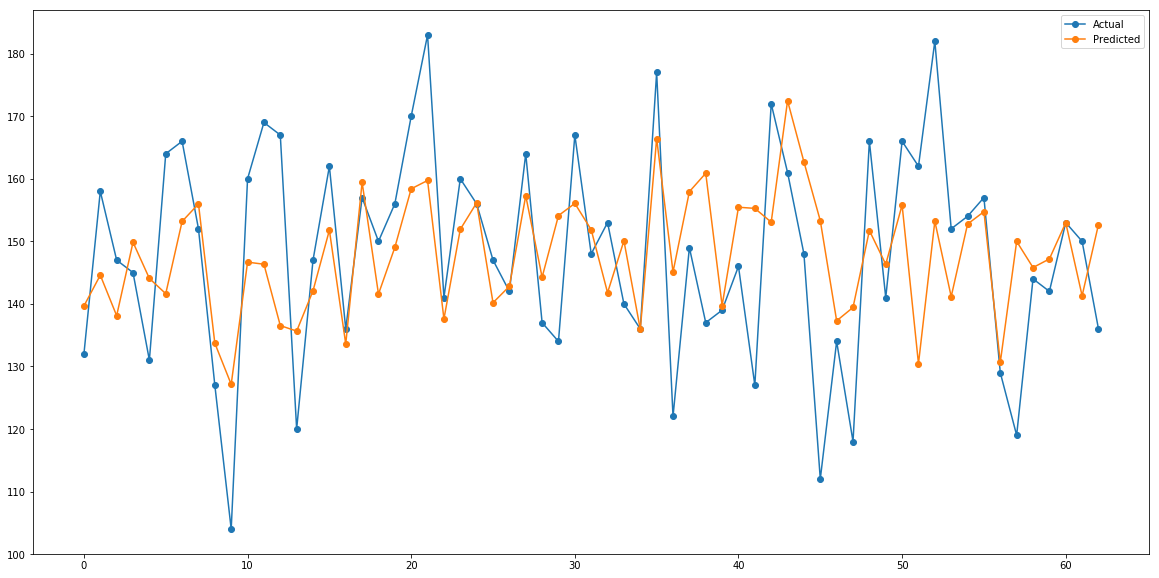

In [20]:

results = train.trainNNsWithTrainData(trainXdata, trainTdata, testXdata,testTdata, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainXdata.shape[1], best[0], trainTdata.shape[1])
nnet.train(trainXdata, trainTdata, nIterations=iterations)
YtestData = nnet.use(testXdata)

plt.figure(figsize=(20,10))
plt.plot(testTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

#### Training neural network with 80% of games from the 1996-2017 seasons as training data and with the remaining 20% as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 15.987051535641246, 15.958398728643894, 0.5396838188171387]
[2, 16.856230706482894, 16.839394824817198, 3.064201831817627]
[5, 17.165271897912323, 17.16112417346622, 2.7565152645111084]
[[4, 4], 16.614693984169321, 16.646315352619972, 3.797842025756836]
[[5, 5], 16.644344238180725, 16.646274829971698, 4.343029975891113]
[[1, 1, 1, 1], 17.721229328809322, 17.811396613146862, 2.716938018798828]
[[3, 3, 3, 3], 17.126095442660308, 17.211785503928812, 4.644361972808838]
[[3, 3, 3, 3, 3], 17.796406630412996, 17.751183004927913, 4.906812906265259]

Best
[0, 15.987051535641246, 15.958398728643894, 0.5396838188171387]



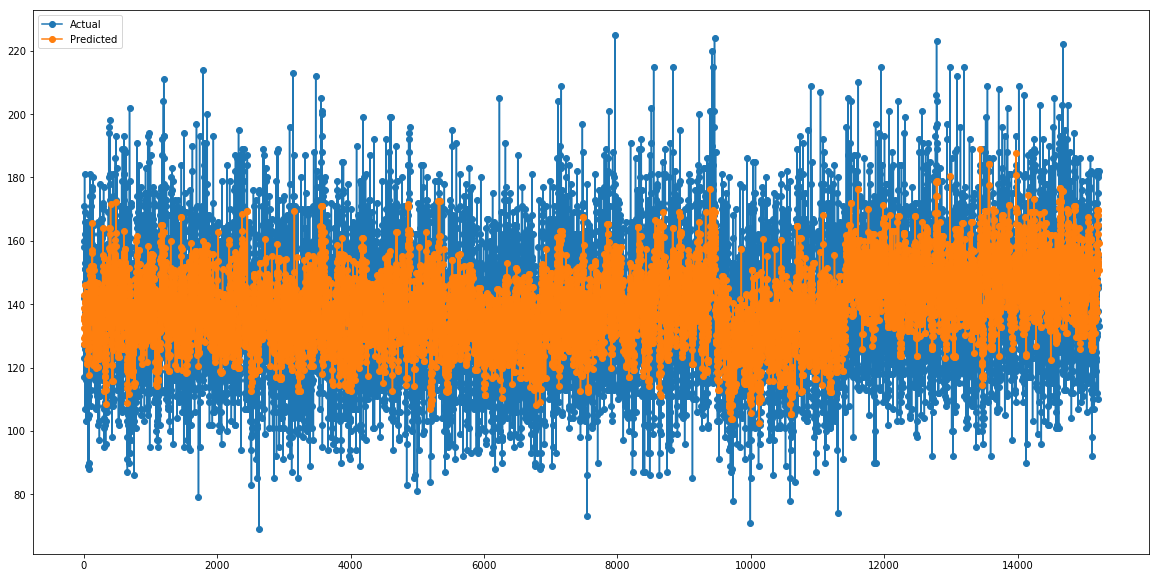

In [43]:
results = train.trainNNs(trainAllXdata, trainAllTdata, .8, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainAllXdata.shape[1], best[0], trainAllTdata.shape[1])
nnet.train(trainAllXdata, trainAllTdata, nIterations=iterations)
YtestData = nnet.use(trainAllXdata)

plt.figure(figsize=(20,10))
plt.plot(trainAllTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

In [44]:
YtestData[:,0]

array([ 135.017304  ,  132.33271776,  142.83244141, ...,  169.75606221,
        150.92503854,  159.34922519])

### Neural Networking testing with classification

In [113]:
trainAllData = format_classification_data(over_under_data)
trainAllTdata = trainAllData[:,-1]
trainAllTdata = np.row_stack(trainAllTdata)
trainAllXdata = trainAllData[:,0:-1]
trainAllTdata.shape, trainAllXdata.shape

((196, 1), (196, 16))

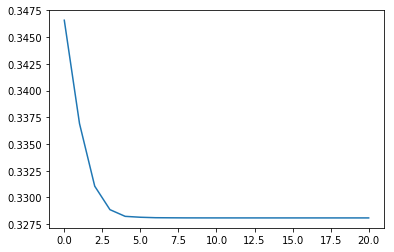

In [114]:
nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], [0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, 20)
plt.plot(nnet.getErrorTrace())

In [115]:
iterations = 10
repetitions = 20
nns = [0,2,5,[4,4],[5,5],[1,1,1,1],[3,3,3,3],[3,3,3,3,3]]

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 0.38407643312101913, 0.50641025641025639, 0.09686279296875]
[2, 0.35000000000000003, 0.53461538461538471, 0.12298393249511719]
[5, 0.34299363057324844, 0.50641025641025639, 0.12654900550842285]
[[4, 4], 0.37993630573248416, 0.52051282051282044, 0.12987327575683594]
[[5, 5], 0.37420382165605104, 0.51025641025641022, 0.175933837890625]
[[1, 1, 1, 1], 0.41433121019108282, 0.50641025641025639, 0.1644282341003418]
[[3, 3, 3, 3], 0.39490445859872614, 0.51666666666666672, 0.32581281661987305]
[[3, 3, 3, 3, 3], 0.40382165605095544, 0.52564102564102577, 0.24054384231567383]

Best
[0, 0.38407643312101913, 0.50641025641025639, 0.09686279296875]

Percent Error:  0.40306122449


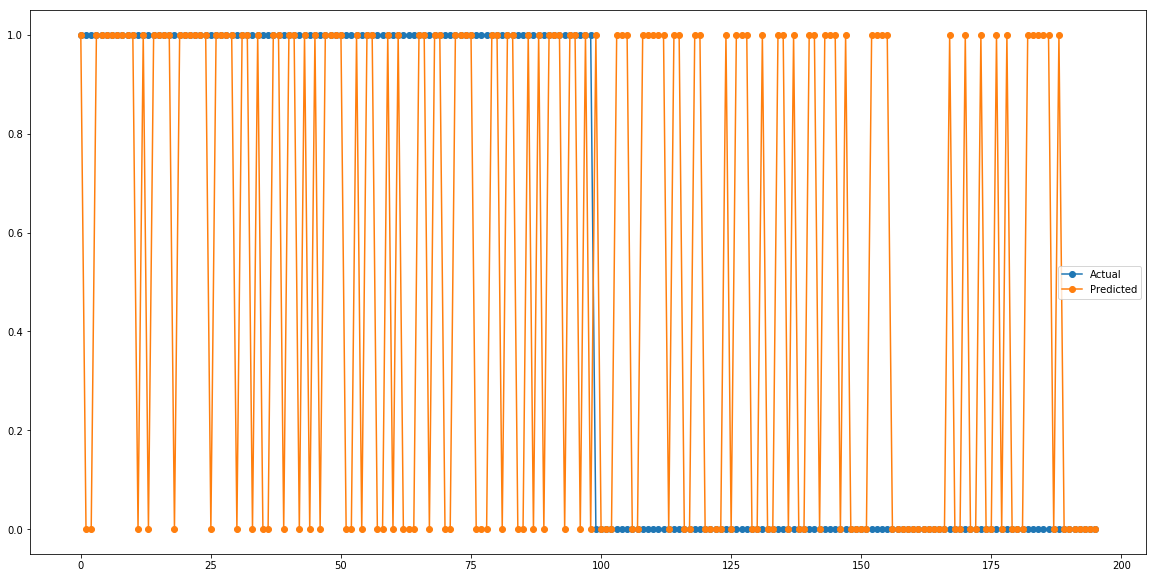

In [121]:
results = train.trainNNs(trainAllXdata, trainAllTdata, .8, nns, repetitions, iterations, True)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], best[0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, nIterations=iterations)
YtestData = nnet.use(trainAllXdata)
plt.figure(figsize=(20,10))
plt.plot(trainAllTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()
print("Percent Error: ",(np.sum(np.abs(YtestData - trainAllTdata)))/trainAllTdata.shape[0])